In [1]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import datetime as dt

from sklearn.neighbors import NearestNeighbors
from random import sample
from numpy.random import uniform
from math import isnan
 

import sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

from scipy.cluster.hierarchy import linkage
from scipy.cluster.hierarchy import dendrogram
from scipy.cluster.hierarchy import cut_tree

In [2]:
data = pd.read_csv("Online_Retail.csv", sep=",", encoding="ISO-8859-1", header=0)

In [3]:
## Data Preprocessing

In [4]:
data.isnull().sum()


InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

In [5]:
data = data.dropna()

In [6]:
data.isnull().sum()

InvoiceNo      0
StockCode      0
Description    0
Quantity       0
InvoiceDate    0
UnitPrice      0
CustomerID     0
Country        0
dtype: int64

In [7]:
data['revenue'] = data['Quantity']*data['UnitPrice']
data.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,revenue
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/01/2010 08:26:00,2.55,17850.0,United Kingdom,15.30
1,536365,71053,WHITE METAL LANTERN,6,12/01/2010 08:26:00,3.39,17850.0,United Kingdom,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/01/2010 08:26:00,2.75,17850.0,United Kingdom,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/01/2010 08:26:00,3.39,17850.0,United Kingdom,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/01/2010 08:26:00,3.39,17850.0,United Kingdom,20.34


In [8]:
revenue_contributed = data.groupby('CustomerID')['revenue'].sum()
revenue_contributed = revenue_contributed.reset_index()
revenue_contributed.head()

,CustomerID,revenue
0,12346.0,0.00
1,12347.0,4310.00
2,12348.0,1797.24
3,12349.0,1757.55
4,12350.0,334.40


In [9]:
frequency = data.groupby('CustomerID')['InvoiceNo'].count()
frequency = frequency.reset_index()
frequency.head()

,CustomerID,InvoiceNo
0,12346.0,2
1,12347.0,182
2,12348.0,31
3,12349.0,73
4,12350.0,17


In [10]:
data['InvoiceDate'] = pd.to_datetime(data['InvoiceDate'], format='%m/%d/%Y %H:%M:%S')
data['duration'] = data['InvoiceDate'].max() - data['InvoiceDate']
data['duration']

0        373 days 04:24:00
1        373 days 04:24:00
2        373 days 04:24:00
3        373 days 04:24:00
4        373 days 04:24:00
                ...       
541904     0 days 00:00:00
541905     0 days 00:00:00
541906     0 days 00:00:00
541907     0 days 00:00:00
541908     0 days 00:00:00
Name: duration, Length: 406829, dtype: timedelta64[ns]

In [11]:
recency = data.groupby('CustomerID')['duration'].min()
recency = recency.reset_index()
recency.head()

,CustomerID,duration
0,12346.0,325 days 02:33:00
1,12347.0,1 days 20:58:00
2,12348.0,74 days 23:37:00
3,12349.0,18 days 02:59:00
4,12350.0,309 days 20:49:00


In [12]:
rf = pd.merge(revenue_contributed, frequency, on='CustomerID', how='inner')
rfm = pd.merge(rf, recency, on='CustomerID', how='inner')
rfm.columns = ['CustomerID', 'revenue', 'frequency', 'recency']
rfm['recency'] = rfm['recency'].dt.days
rfm.head()

,CustomerID,revenue,frequency,recency
0,12346.0,0.00,2,325
1,12347.0,4310.00,182,1
2,12348.0,1797.24,31,74
3,12349.0,1757.55,73,18
4,12350.0,334.40,17,309


In [13]:
## Outlier Treatment

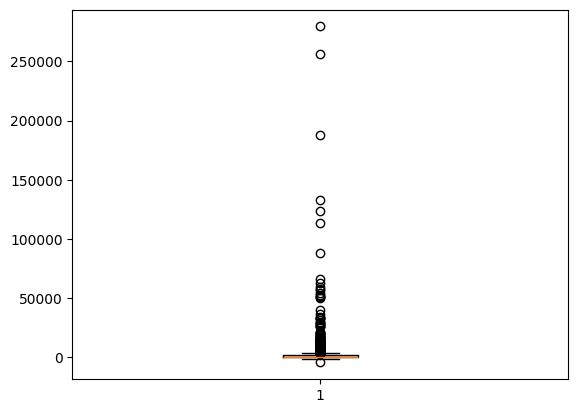

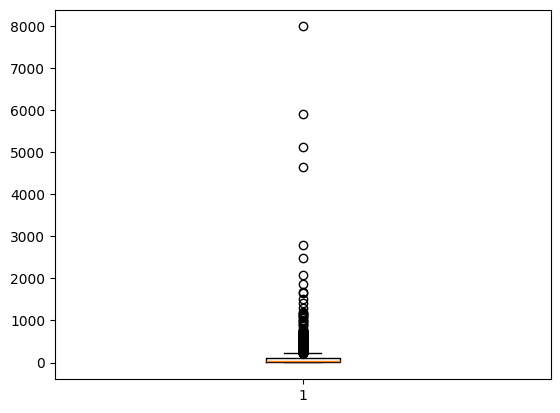

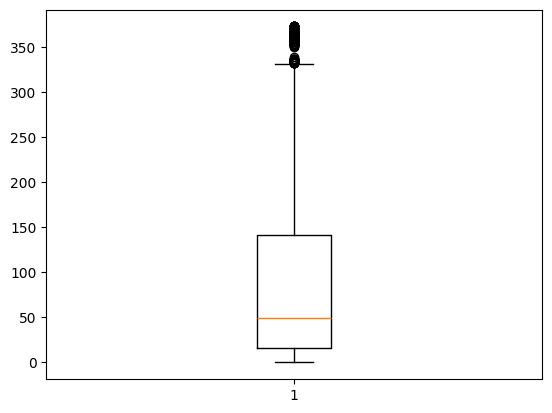

In [14]:
plt.boxplot(rfm['revenue'])
plt.show()
plt.boxplot(rfm['frequency'])
plt.show()
plt.boxplot(rfm['recency'])
plt.show()

In [15]:
## The IQR method helps in identifying outliers by looking at the middle 50% of your data, which is the range between the first quartile (Q1) and the third quartile (Q3). The IQR is calculated as the difference between Q3 and Q1. Outliers are typically defined as any values that fall below Q1 - 1.5 * IQR or above Q3 + 1.5 * IQR.
q1_rev = rfm['revenue'].quantile(0.05)
q3_rev= rfm['revenue'].quantile(0.95)
IQR = q3_rev - q1_rev
rfm = rfm[(rfm['revenue'] >= q1_rev - 1.5*IQR) & (rfm['revenue'] <= q3_rev + 1.5*IQR)]

q1_freq = rfm['frequency'].quantile(0.05)
q3_freq = rfm['frequency'].quantile(0.95)
IQR = q3_freq - q1_freq
rfm = rfm[(rfm['frequency'] >= q1_freq - 1.5*IQR) & (rfm['frequency'] <= q3_freq + 1.5*IQR)]

q1_rec = rfm['recency'].quantile(0.05)
q3_rec = rfm['recency'].quantile(0.95)
IQR = q3_rec - q1_rec
rfm = rfm[(rfm['recency'] >= q1_rec - 1.5*IQR) & (rfm['recency'] <= q3_rec + 1.5*IQR)]

In [16]:
## Using StandardScaler from scikit-learn is a good approach to normalize your data. Standardization ensures that each feature (revenue, frequency, and recency) has a mean of 0 and a standard deviation of 1. This process is important for many machine learning algorithms, including clustering, as it ensures that features are on the same scale and no single feature dominates the others.
scale = StandardScaler()
cols = ['revenue', 'frequency', 'recency']
rfm_scaler = scale.fit_transform(rfm[cols])

In [17]:
## Why Standardize?: Think of it like comparing apples to oranges. Spending, frequency, and recency are on different scales (e.g., dollars, number of purchases, days). Standardizing puts them on the same scale, making comparisons fairer | Used a tool called StandardScaler that adjusts the data so that each feature (revenue, frequency, recency) has an average value of 0 and a consistent spread of values.

In [18]:
rfm_scaled = pd.DataFrame(rfm_scaler)
rfm_scaled.columns = ['revenue', 'frequency', 'recency']
rfm_scaled.head()

,revenue,frequency,recency
0,-0.723738,-0.752888,2.301611
1,1.731617,1.042467,-0.906466
2,0.300128,-0.463636,-0.183658
3,0.277517,-0.044720,-0.738141
4,-0.533235,-0.603275,2.143188


In [19]:
## Building the Model

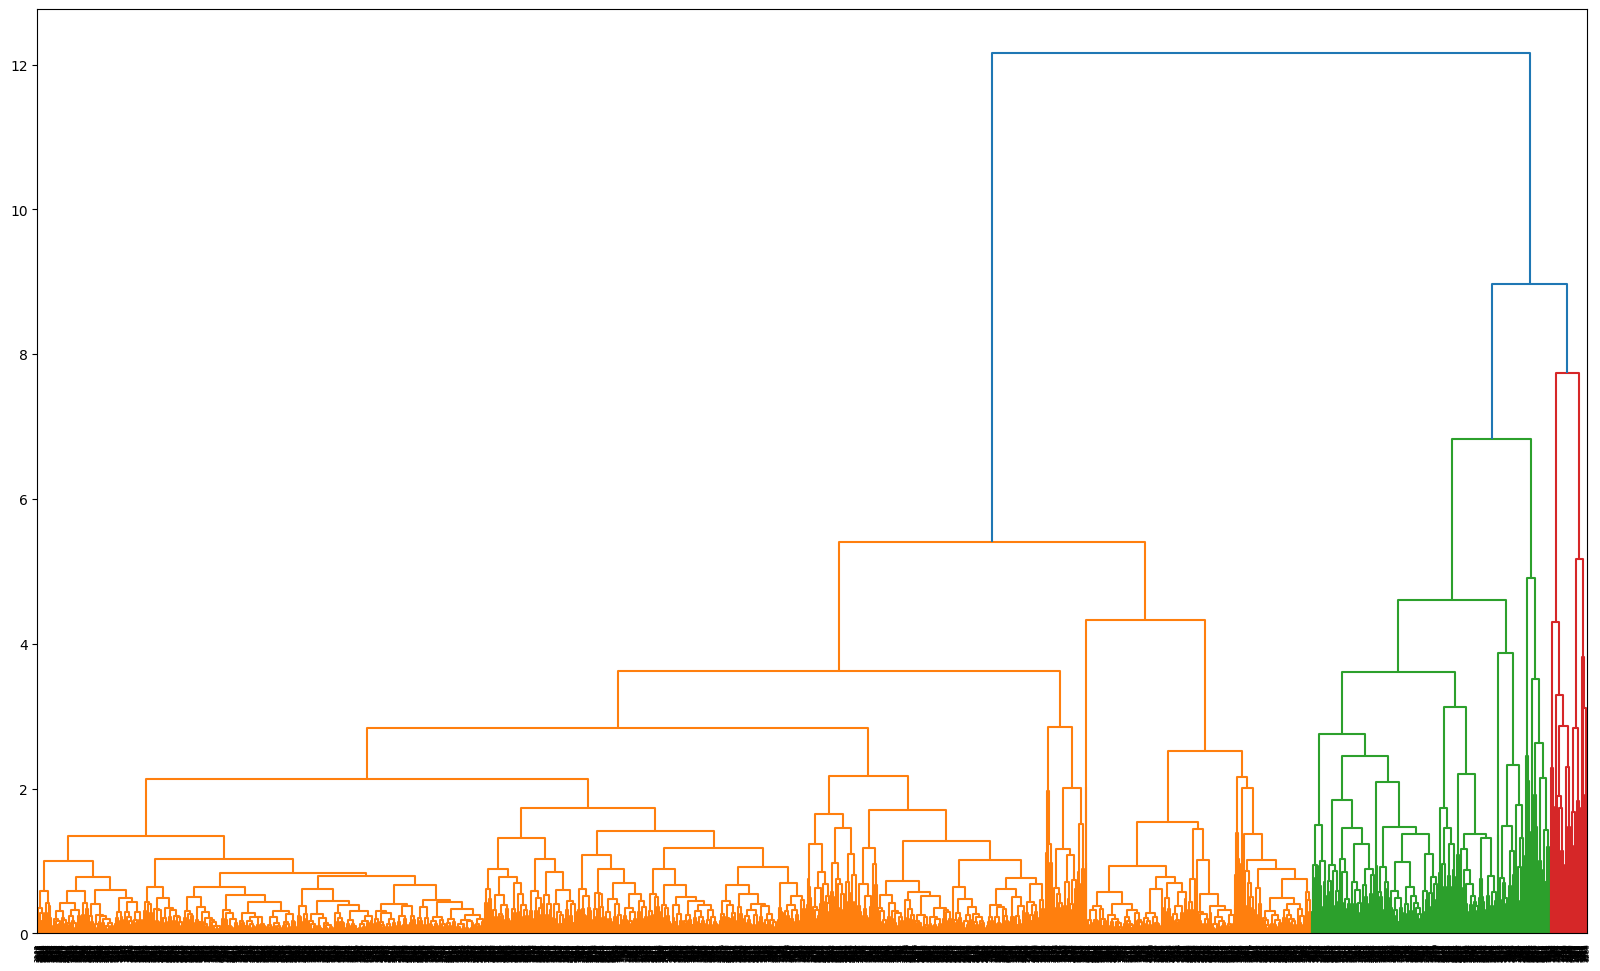

In [20]:
## Use the 'linkage' function with the 'complete' method and 'euclidean' metric to compute the hierarchical clustering.
plt.figure(figsize=(20,12))
mergings = linkage(rfm_scaled, method="complete", metric='euclidean')
dendrogram(mergings)
plt.show()

In [21]:
cluster_labels = cut_tree(mergings, n_clusters=3).reshape(-1, )
cluster_labels

array([0, 1, 0, ..., 0, 0, 0], dtype=int64)

In [22]:
pd.set_option('display.max_rows', None)
rfm['cluster_labels'] = cluster_labels
rfm.head(90)

,CustomerID,revenue,frequency,recency,cluster_labels
0,12346.0,0.000000e+00,2,325,0
1,12347.0,4.310000e+03,182,1,1
2,12348.0,1.797240e+03,31,74,0
3,12349.0,1.757550e+03,73,18,0
4,12350.0,3.344000e+02,17,309,0
5,12352.0,1.545410e+03,95,35,0
6,12353.0,8.900000e+01,4,203,0
7,12354.0,1.079400e+03,58,231,0
8,12355.0,4.594000e+02,13,213,0
9,12356.0,2.811430e+03,59,22,1


<Axes: xlabel='cluster_labels', ylabel='recency'>

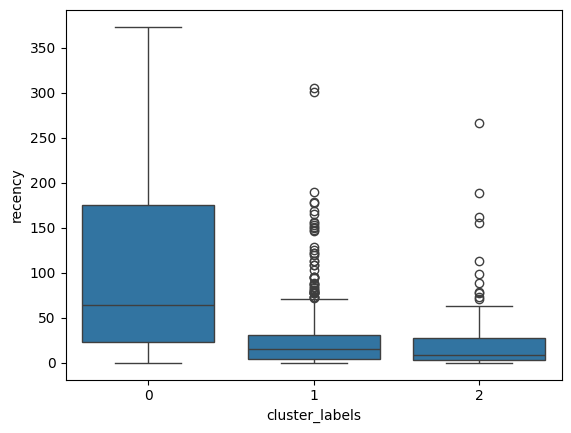

In [23]:
sns.boxplot(x='cluster_labels', y='recency', data=rfm)

<Axes: xlabel='cluster_labels', ylabel='frequency'>

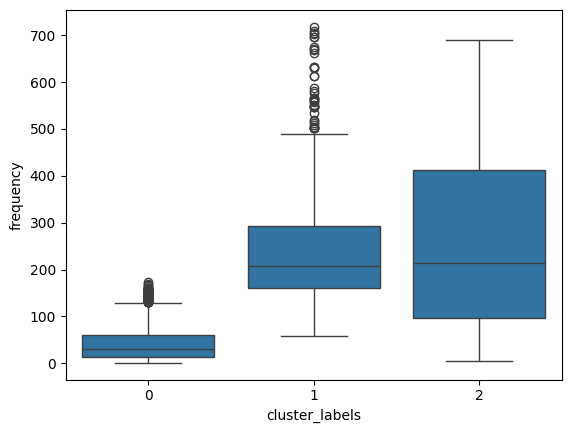

In [24]:
sns.boxplot(x='cluster_labels', y='frequency', data=rfm)

<Axes: xlabel='cluster_labels', ylabel='revenue'>

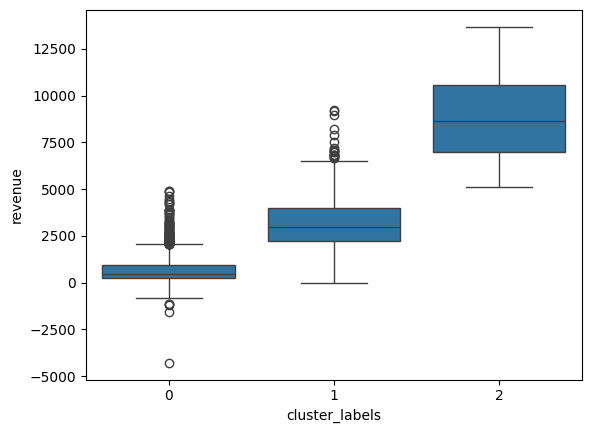

In [25]:
sns.boxplot(x='cluster_labels', y='revenue', data=rfm)